In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer 
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as ms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris

### iris data를 이용한 의사결정 트리 feature 중요도

In [2]:
# 분류기 생성
dtc_iris = DecisionTreeClassifier(random_state = 100)

# 데이터 로드 및 전처리
iris_data = load_iris()

# 분리
# 학습, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = .2, random_state = 100)

# 학습
dtc_iris.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

In [3]:
from sklearn.tree import export_graphviz

# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(
    dtc_iris, out_file = "./data/tree.dot", 
    class_names = iris_data.target_names, 
    feature_names = iris_data.feature_names, 
    impurity = True, 
    filled = True
)

In [5]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

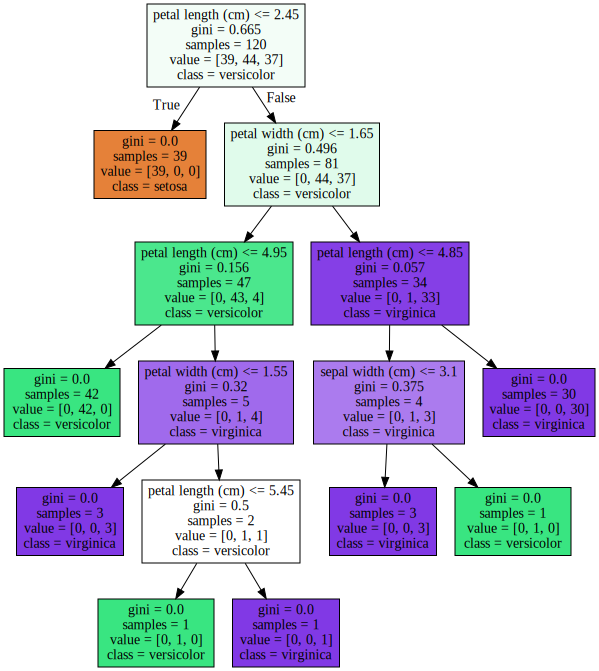

In [6]:
import graphviz

with open('./data/tree.dot') as f :
    dot_graph = f.read()

graphviz.Source(dot_graph)

sepal length (cm) 0.0
sepal width (cm) 0.01880091915604763
petal length (cm) 0.5859134473686348
petal width (cm) 0.39528563347531753


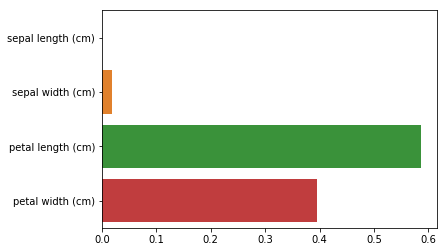

In [9]:
# feature 중에서 가장 중요도가 높은 feature 선정
# print('feature importance :', dtc_iris.feature_importances_)

for name, value in zip(iris_data.feature_names, dtc_iris.feature_importances_) :
    print(name, value)

sns.barplot(x = dtc_iris.feature_importances_, y = iris_data.feature_names)

In [ ]:
# 의사결정트리의 단점
# 과적합 : 학습데이터에서 완벽한 성능을 보이지만 테스트데이터에서 성능이 좋지 않은 경우
# 과적합을 위해서 분류용 가상의 데이터를 생성 -> make_classification()

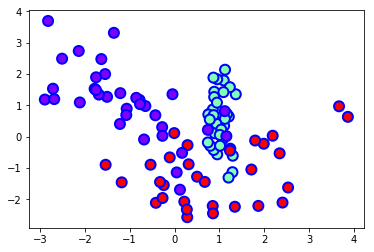

In [24]:
from sklearn.datasets import make_classification

# 가상 데이터 생성
X_features, y_labels = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_clusters_per_class = 1, n_classes = 3, random_state = 0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker = 'o', c = y, s = 100, edgecolor = 'b', linewidth = 2, cmap = 'rainbow')

# plt.title('1개의 독립변수를 가진 가상 데이터')
plt.show()

In [25]:
# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y) :
    fig, ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c = y, s = 25, cmap = 'rainbow', edgecolor = 'k', clim = (y.min(), y.max()), zorder = 3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num = 200), np.linspace(ylim_start, ylim_end, num = 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha = 0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim = (y.min(), y.max()), zorder = 1)

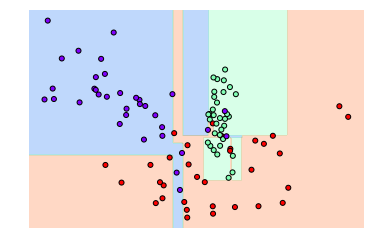

In [26]:
sample_dtc_model = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(sample_dtc_model, X_features, y_labels)

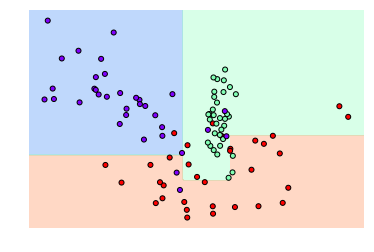

In [27]:
# 튜닝을 통한 과적합 해결

# max_depth 줄여서 트리의 깊이를 제한 -> sample의 개수는 많아진다.
# min_samples_split 늘여서 데이터가 분할하는데 필요한 샘플데이터의 수를 높이기
# min_samples_leaf 높여서 말단 노드가 되는데 필요한 샘플데이터의 수를 높이기
# max_features 높여서 분할을 하는데 고려하는 feature의 수 제한

sample_dtc_model = DecisionTreeClassifier(min_samples_leaf = 6).fit(X_features, y_labels)
visualize_boundary(sample_dtc_model, X_features, y_labels)

### UCL 결정트리 [실습]

In [97]:
# 데이터셋을 구성하는 함수 설정
def har_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])
    # display(feature_name_df)
    
    # 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
    feature_name = feature_name_df.iloc[:, 1].values.tolist()
    # print(feature_name)
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
    # 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/train/X_train.txt', sep = '\s+', names  =feature_name)
    X_test = pd.read_csv('./data/test/X_test.txt', sep = '\s+', names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/train/y_train.txt', sep = '\s+', names = ['action'])
    y_test = pd.read_csv('./data/test/y_test.txt', sep = '\s+', names = ['action'])
    
    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return X_train, X_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = har_dataset()

In [99]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [100]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [105]:
y_train.head(10)

,action
0,5
1,5
2,5
3,5
4,5
5,5
6,5
7,5
8,5
9,5


In [106]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [75]:
# 튜닝없이 예측
# default로 예측한 결과

har_dtc = DecisionTreeClassifier(random_state = 120)
# print('parameter :', har_dtc.get_params())
har_dtc.fit(X_train, y_train)
y_pred = har_dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Decision Tree 예측값 :', accuracy)

Decision Tree 예측값 : 0.8598574821852731


In [76]:
# max_depth가 정확도에 주는 영향
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(har_dtc, param_grid = params, scoring = 'accuracy', cv = 5)
grid_cv.fit(X_train, y_train)
print('최고 평균 정확도 수치  :', grid_cv.best_score_)
print('최적의 하이퍼 파라미터 :', grid_cv.best_params_)

최고 평균 정확도 수치  : 0.846573990575156
최적의 하이퍼 파라미터 : {'max_depth': 6}


In [107]:
# max_depth가 크면 과적합으로 인해 성능이 하락하는지 확인
max_depths = [6, 10, 12, 16, 20, 24, 28]

for depth in max_depths :
    har_dtc = DecisionTreeClassifier(max_depth = depth, random_state = 100)
    har_dtc.fit(X_train, y_train)
    y_pred = har_dtc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('max_depth : {}, Desicion Tree 예측값 : {}'.format(depth, accuracy))

max_depth : 6, Desicion Tree 예측값 : 0.8537495758398371
max_depth : 10, Desicion Tree 예측값 : 0.8673227010519172
max_depth : 12, Desicion Tree 예측값 : 0.8561248727519511
max_depth : 16, Desicion Tree 예측값 : 0.8544282321004412
max_depth : 20, Desicion Tree 예측값 : 0.8506956226671191
max_depth : 24, Desicion Tree 예측값 : 0.8506956226671191
max_depth : 28, Desicion Tree 예측값 : 0.8506956226671191


In [108]:
# max_depth가 정확도에 주는 영향
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(har_dtc, param_grid = params, scoring = 'accuracy', cv = 5)
grid_cv.fit(X_train, y_train)
print('최고 평균 정확도 수치  :', grid_cv.best_score_)
print('최적의 하이퍼 파라미터 :', grid_cv.best_params_)

최고 평균 정확도 수치  : 0.854742805347836
최적의 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [109]:
# 해당 파라미터를 적용해서 예측 수행
best_params_dtc = grid_cv.best_estimator_
print(best_params)
best_pred = best_params_dtc.predict(X_test)
accuracy = accuracy_score(y_test, best_pred)
print('예측 정확도 :', accuracy)

DecisionTreeClassifier(max_depth=20, min_samples_split=24, random_state=120)
예측 정확도 : 0.8717339667458432


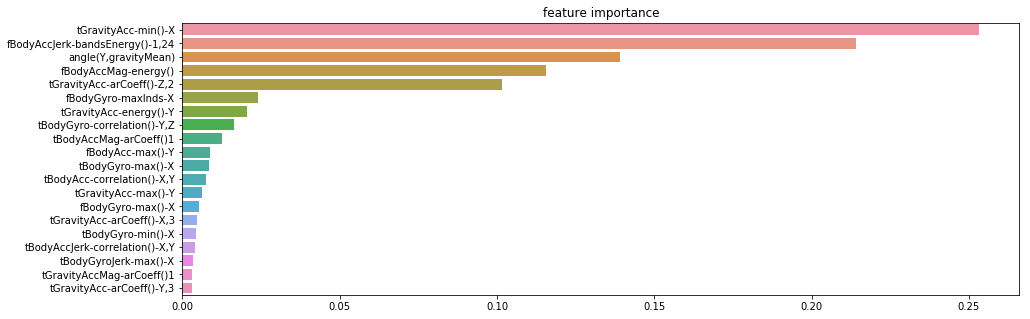

In [110]:
# best_params_dtc.feature_importances_

# 피쳐 중요도를 시각화 top20
feature_importances = pd.Series(best_params_dtc.feature_importances_, index = X_train.columns)
# feature_importances
feature_top20 = feature_importances.sort_values(ascending = False)[:20]
feature_top20

plt.figure(figsize = (15, 5))
plt.title('feature importance')
sns.barplot(x = feature_top20, y = feature_top20.index)

plt.show()